# OpenCV Filters HDMI

In this notebook, several filters will be applied to HDMI input images.

Those input sources and applied filters will then be displayed either directly in the notebook or on HDMI output.

To run all cells in this notebook a HDMI input source and HDMI output monitor are required.  

## 1. Start HDMI input and output 
### Step 1: Load the overlay

In [9]:
from pynq import Overlay
Overlay("vbx.bit").download()


### Step 2: Initialize HDMI I/O

In [10]:
from pynq.drivers import HDMI
from pynq.drivers.video import VMODE_1920x1080,VMODE_1280x720
vmode=VMODE_1280x720
#vmode=VMODE_1920x1080
hdmi_out = HDMI('out',video_mode=vmode)
hdmi_in = HDMI('in',  video_mode=vmode,frame_list=hdmi_out.frame_list)
hdmi_in.start()
hdmi_out.start()

### Step 3: Show HDMI input frame within notebook using IPython Image

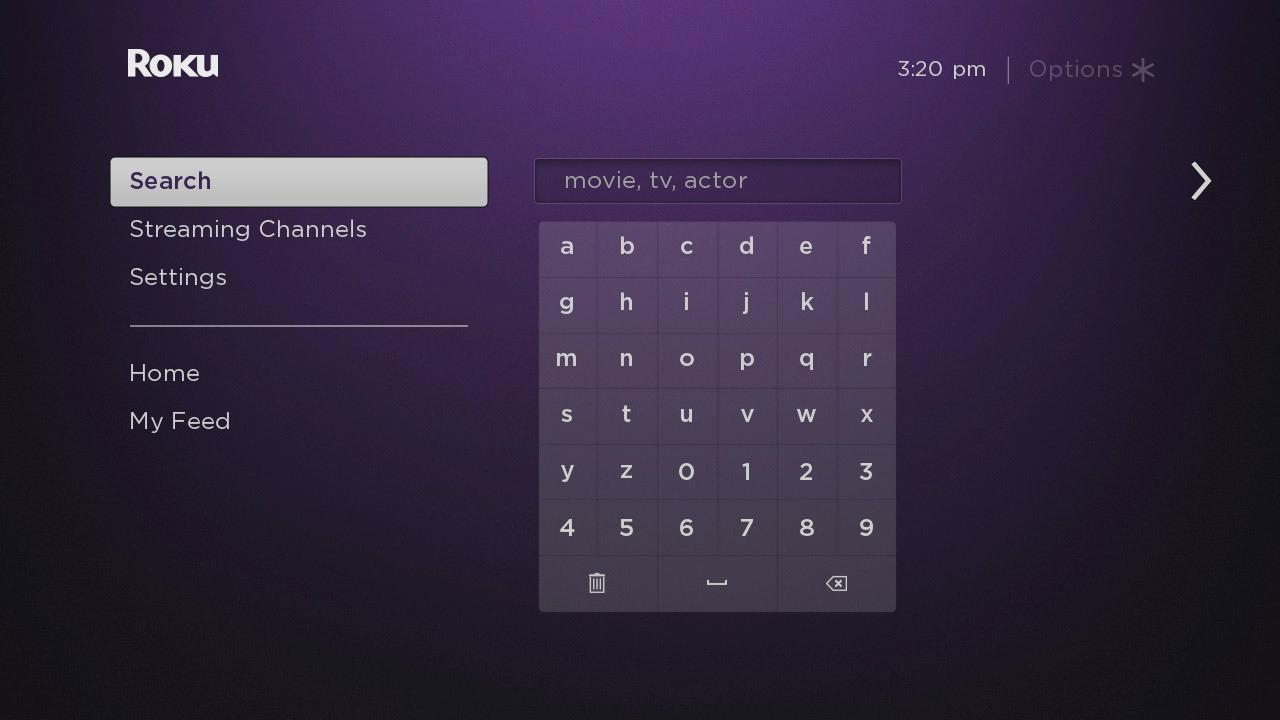

In [4]:
from IPython.display import Image
frame = hdmi_in.frame()
orig_img_path = '/home/xilinx/jupyter_notebooks/examples/' + \
                'data/mxp_filters.jpg'
frame.save_as_jpeg(orig_img_path)

Image(filename=orig_img_path)

## 2. Applying Sobel filters on HMDI input with Python

### Step 1: Disconnect HDMI out from HDMI in
The `hdmi_in` will now stream to different frame buffer (no longer connected to `hdmi_out`).

In [5]:
hdmi_in.frame_index_next()

1

### Step 2: Edge detection
Detecting edges on HDMI in and display on HDMI out with Laplacian filter.

In [7]:
import time
import cv2
import numpy as np

num_frames = 20

start = time.time()

for i in range (num_frames):    
    np_frame= (np.frombuffer(hdmi_in.frame_raw(), 
                             dtype=np.uint8)).reshape(1080,1920,3)
    
    gray_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2GRAY) 
    sobel_frame=cv2.Sobel(gray_frame,ddepth=-1,dx=1,dy=1)

    sobel_rgb_frame=cv2.cvtColor(sobel_frame, cv2.COLOR_GRAY2RGB) 
    hdmi_out.frame_raw(bytearray(sobel_rgb_frame.tobytes()))
    
end = time.time()

print("Frames per second:  " + str((num_frames) / (end - start)))

Frames per second:  2.392494978064111


### Step 3: Show same results within notebook
Output OpenCV results as JPEG.

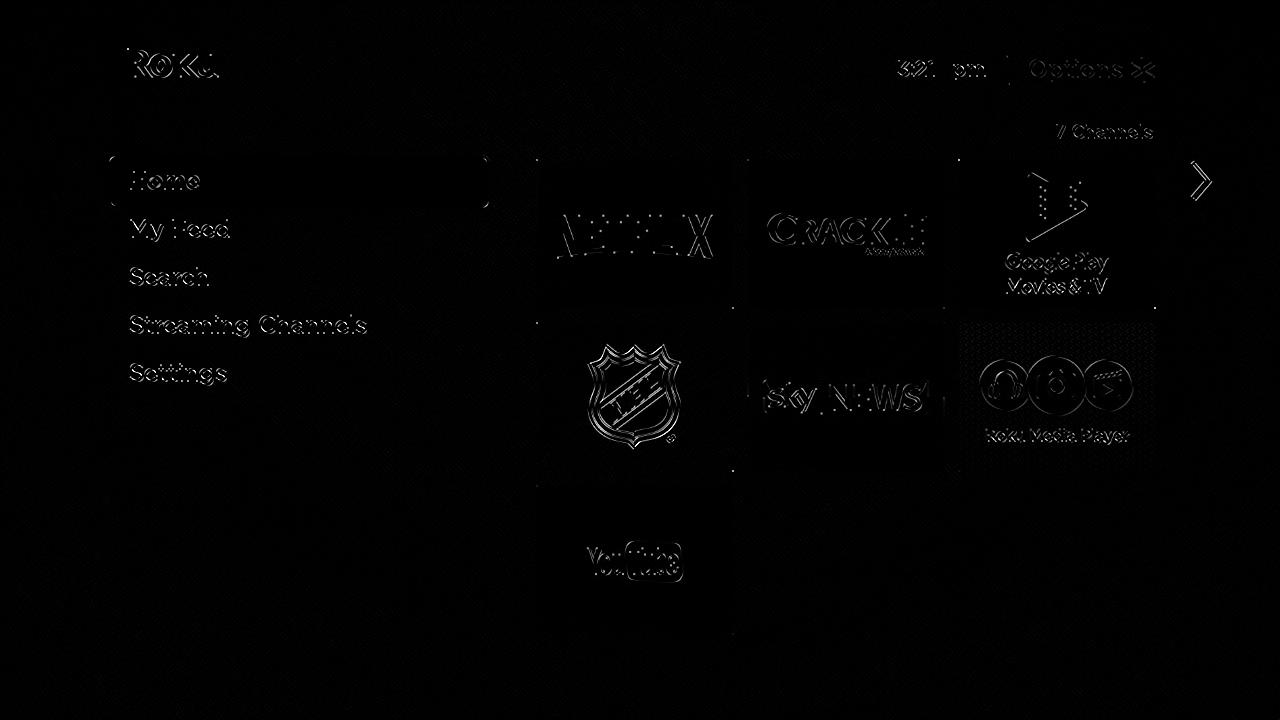

In [7]:
from IPython.display import Image
orig_img_path = '/home/xilinx/jupyter_notebooks/examples/' + \
                'data/opencv_filters.jpg'
hdmi_out.frame().save_as_jpeg(orig_img_path)

Image(filename=orig_img_path)

## 3. Applying Sobel filters on HMDI input with MXP


### Step 1: Edge detection
Create filter function

In [4]:
from pynq.iop.mxp_filter import MXP_Filter

filter_text="""
void filter(uint8_t* in_vid,uint8_t* out_vid,int rows, int cols,int pitch){
	int rowlen=cols;
	// save scratchpad allocator state
	vbx_sp_push();
	vbx_ubyte_t* line_in= vbx_sp_malloc(rowlen*3);

	vbx_word_t* v_tmp0=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* v_tmp1=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* v_tmp2=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* luma_top=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* luma_mid=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* luma_bot=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* sobel_top=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* sobel_mid=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* sobel_bot=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* grad_x=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));
	vbx_word_t* grad_y=vbx_sp_malloc(rowlen*sizeof(vbx_word_t));


	int row;
	for(row=0;row<rows;row++){
		//load a row into scratchpad
		vbx_dma_to_vector(line_in,in_vid+row*pitch*3,rowlen*3);

		//extract each channel into seperate vectors
		//multiply by a facto for combining into luma
		vbx_set_vl(1);
		vbx_set_2D(rowlen,sizeof(vbx_word_t),3,3);
		vbx_2D(SVBWU,VMUL,(vbx_uword_t*)v_tmp0,66,line_in+0);
		vbx_2D(SVBWU,VMUL,(vbx_uword_t*)v_tmp1,129,line_in+1);
		vbx_2D(SVBWU,VMUL,(vbx_uword_t*)v_tmp2,25,line_in+2);

		//convert to luma
		vbx_set_vl(rowlen);
		vbx(VVW,VADD,luma_bot,v_tmp0,v_tmp1);
		vbx(VVW,VADD,luma_bot,luma_bot,v_tmp2);
		vbx(SVW,VSHR,luma_bot,8,luma_bot);

		/// Apply [1 2 1] to input luma row
		vbx_set_vl(rowlen-1);
		vbx(VVW,VADD,sobel_bot,luma_bot,luma_bot+1);
		vbx_set_vl(rowlen-2);
		vbx(VVW,VADD,sobel_bot,sobel_bot,sobel_bot+1);

		if (row>1){

			// |grad_y|  = |sobel_top - sobel_bot|;
			vbx(VVW,VABSDIFF,grad_y,sobel_top,sobel_bot);

			//grad_x = | 1 0 -1 |
			//         | 2 0 -2 |  * luma
			//         | 1 - -1 |
			vbx_set_vl(rowlen);
			vbx(VVW,VADD,v_tmp0,luma_top,luma_mid);
			vbx(VVW,VADD,v_tmp1,luma_bot,luma_mid);
			vbx(VVW,VADD,v_tmp0,v_tmp0,v_tmp1);

			vbx_set_vl(rowlen-2);
			vbx(VVW,VABSDIFF,grad_x,v_tmp0,v_tmp0+2);

			//sum gradiaents and threshold at 255
			vbx_word_t* row_out=grad_x;
			vbx(VVW,VADD,row_out,grad_x,grad_y);
			vbx(SVW,VSUB,v_tmp0,255,row_out);
			vbx(SVW,VCMV_LTZ,row_out,255,v_tmp0);

			//copy to other bytes of word
			vbx(SVW,VMUL,row_out,0x010101,row_out);

			//pack into RGB
			vbx_set_vl(3);
			vbx_set_2D(rowlen-2,3,sizeof(vbx_word_t),0);
			vbx_2D(VVB,VMOV,(vbx_byte_t*)row_out,(vbx_byte_t*)row_out,0);
			vbx_byte_t *out=out_vid+((row-1)*pitch + 1)*3;
			vbx_dma_to_host(out,row_out,(rowlen-2)*3);
		}

		//rotate rows
		{
			vbx_word_t* aa;
			aa=luma_top;
			luma_top=luma_mid;
			luma_mid=luma_bot;
			luma_bot=aa;

			aa=sobel_top;
			sobel_top=sobel_mid;
			sobel_mid=sobel_bot;
			sobel_bot=aa;
		}

	}

	//blackout outside pixels
	vbx_set_vl(rowlen*3);
	vbx(SVBU,VMOV,line_in,0,0);

	//top row
	vbx_dma_to_host(out_vid,line_in,rowlen*3);
	//bottom row
	vbx_dma_to_host(out_vid+(rows-1)*rowlen*3,line_in,rowlen*3);
	//left column
	vbx_dma_to_host_2D(out_vid,line_in,3,cols,pitch*3,0);
	//right column
	vbx_dma_to_host_2D(out_vid+(rowlen-1)*3,line_in,3,cols,rowlen*3,0);

	//restore scratchpad allocator state
	vbx_sp_pop();

	//make sure all dma operations are complete before exiting
	vbx_sync();
}"""
filter_bin=MXP_Filter(filter_text)

     

### Step 2. Call mxp filter and compare timing


In [6]:
import time
filter_bin.start()
start = time.time()

for i in range (num_frames):    
    in_video = hdmi_in.frame_phyaddr()
    out_video= hdmi_out.frame_phyaddr()
    filter_bin.call(in_video,out_video,720,1280,1920)
end = time.time()
filter_bin.stop()
print("Frames per second:  " + str((num_frames) / (end - start)))

NameError: name 'num_frames' is not defined

Notice how much faster than the python implementation the MXP version is. When you look at the hdmi output you can start to notice pretty bad tearing in the image, You porobably want to add some more sophisticated frame buffer management if you want to fix this.

## 4. Release HDMI

In [8]:
hdmi_out.stop()
hdmi_in.stop()
del hdmi_in, hdmi_out